# Implementing a Gibbs Sampler for the Uninitiated with Python

## <a id="table-of-contents">Table of Contents</a>
1. [Introduction](#introduction)
2. [Hyperparameters and Random Variables in Codes](#hyperparameters-and-random-variables)

Go to [The end](#the-end)

## <a id="introduction">1. Introduction</a> (Back to [Table of Contents](#table-of-contents))

This article is inspired by the _masterpiece_ of [**Gibbs Sampling tutorial**](https://maranathaedu-my.sharepoint.com/:b:/g/personal/hendra_bunyamin_it_maranatha_edu/EZA9beLgBdZPip9br-UrdSAB024P8IBGESYAbJP3MfRQFQ?e=HdMzZ9) by _Resnik and Hardisty_ and also an _awesome_ [**github repo**](https://github.com/bobflagg/gibbs-sampling-for-the-uninitiated) by _Bob Flagg_.      
Both of these resources are excellent and highly recommended for anyone to read.

This article will show a step by step implementation of a Gibbs sampler for a Naive Bayes model in Python.    
Let us start with the problem definition. Assume that we would like to classify whether or not the sentiment of a document is either $0$ (negative) or $1$ (positive) visualized by the following image.
<img src="sentiment-positive-negative.jpeg" alt="Drawing" style="width: 550px;"/>([_image source_](https://towardsdatascience.com/cnn-sentiment-analysis-1d16b7c5a0e7))     

Moreover, the image below is the generative story of how the documents are generated as explained in $\S$2.1 of the paper.   
<img src="naive-bayes-graphical-model.png" alt="Drawing" style="width: 550px;"/>

Let's recall some of the notations from the paper. There are $6$ variables in the image. We shall discuss these one by one.     

$\pmb{\gamma_\pi}$ is a _vectorized version of hyperparameters_ from a **Beta** distribution. In the literature (Gelman et al., 2014), these hyperparameters usually are represented by $\alpha$ and $\beta$. In the paper, they are $\gamma_{\pi0}$ and $\gamma_{\pi1}$. Specifically, $\pmb{\gamma_\pi}$ is defined as follows:        
$$\begin{equation}
    \pmb{\gamma_\pi} = \begin{bmatrix} \gamma_{\pi0} \\ \gamma_{\pi1} \end{bmatrix}.
\end{equation} \tag{1}\label{eq:gamma-pi}$$    
    
Secondly, $\pi$ is a random variable which has a **Beta** distribution, in other words 
$$\begin{equation}
    \pi \sim \text{Beta}(\gamma_{\pi0}, \gamma_{\pi1}) \tag{2}\label{eq:beta}. 
\end{equation}$$
             
Thirdly, $L_j$ is a random variable for $j$th document which has a **Bernoulli** distribution, 
$$\begin{equation}
    L_j \sim \text{Bernoulli}(\pi) \tag{3}\label{eq:binomial}. 
\end{equation}$$     
    
Fourthly, $\pmb{\gamma_{\theta}}$ is a hyperparameter vector whose dimension is **the size of vocabulary** ($V$) and provided for a **Dirichlet** distribution. In the literature (Gelman et al., 2014), these hyperparameters usually are represented by $\alpha_1$, $\alpha_2$, $\ldots$, $\alpha_V$. In the paper, it is defined as a vector defined as follows: 

$$ \begin{equation}
    \pmb{\gamma_{\theta}} = \begin{bmatrix} 
            \gamma_{\theta1} \\
            \gamma_{\theta2} \\
            \vdots \\
            \gamma_{\theta V}
        \end{bmatrix} = \begin{bmatrix} 
            1 \\
            1 \\
            \vdots \\
            1
        \end{bmatrix} \tag{4}\label{eq:gamma-theta}. 
\end{equation}
$$
   
Fifthly, $\pmb{\theta}$ is a vector which contains two random variables, $\theta_0$ and $\theta_1$. Specifically, both $\theta_0$ and $\theta_1$ are **Dirichlet** distributions with $\pmb{\gamma_{\theta}}$ as their hyperparameters,
$$\begin{align}
    \theta_0 &\sim \text{Dirichlet}(\pmb{\gamma_{\theta}}) \tag{5}\label{eq:dirichlet-1}, \\
    \theta_1 &\sim \text{Dirichlet}(\pmb{\gamma_{\theta}}) \tag{6}\label{eq:dirichlet-2}.         
\end{align}$$     

Last but not least, $\pmb{W}_j$ represents a probability distribution of $j$th document which modeled by a **Multinomial** distribution. As the $j$th document has $R_j$ words and probabilities of each word in the vocabulary, the **Multinomial** distribution is stated as follows:
$$ \begin{equation}
    \pmb{W}_j \sim \text{Multinomial}(R_j, \theta_{L_j}), \text{ for }j = 1, \ldots, N. \tag{7}\label{eq:multinomial}
\end{equation}$$


Hopefully, now that we know what those variables are, we can move forward by programming them. 

Let us import all the libraries

In [5]:
# import all the libraries
import numpy as np
from numpy.random import beta, binomial, dirichlet

## <a id="hyperparameters-and-random-variables">2. Hyperparameters and Random Variables in Codes</a>

As the latent variable $\pi$ can be integrated out (see $\S$2.4.3 of the paper), the state of the model at an iteration step is determined by current values of variables, as follows: 
1. the predicted labels $\pmb{L}$, in code $\Rightarrow$ `L` with the size (`num_docs`,)     
2. the topics $\bf \theta_0$ and $\bf \theta_1$, in code $\Rightarrow$ `theta`, 
3. for each word $k$, the number of times it occurs is $W_{jk}$ (in code, `W`),
4. the number of documents labelled $0$, $C_0$ (in code `C[0]`), and 
5. the number of documents labelled $1$, $C_1$ (in code `C[1]`).    

Let us sample the labels (`L`) for `N` documents with hyperparameters, $\gamma_{\pi}$

| Priority apples | Second priority | Third priority |
|-------|--------|---------|
| ambrosia | gala | red delicious |
| pink lady | jazz | macintosh |
| honeycrisp | granny smith | fuji |

|Paper| Code | Dimension of the variables      |
|-------|-------|-------        |
|$\pmb{L}$|`L` | $\# \text{docs} \times 1$ |     
|$\mathcal{N}_{\mathbb{C}}$|`L` | $\# \text{docs} \times 1$ |     

Let's sample labels for all documents.

In [8]:
def sample_labels(N, gamma_pi):
    '''
    Sample labels for N documents according to Beta distribution with hyperparameters=gamma_pi
    
    Parameters
    ----------
    N: int
        number of documents        
    gamma_pi: list with len=2
        hyperparameters of the Beta distribution        
        
    Returns
    -------
    array with shape (N,)
        Labels for the N documents
    '''
    # pi is the Beta distribution with 
    pi = beta(gamma_pi[0], gamma_pi[1])
    
    return binomial(1, pi, N)

In [9]:
# =========================================================================================================
#       DEMO for sample labels
# 
# In this demo, we sample 5 labels for 5 documents, with alpha = 1 and beta = 1; this is just a uniform
# distribution
# =========================================================================================================
sample_labels(5, [1,1] )


array([0, 0, 0, 0, 1])

In the code below, the this state will be represented as a dictionary
with the following keys: 'L' for the predicted labels, 'theta' for the topics, 'cnts' for word counts and 'C' 
for document counts.

How to initialize our sampler is described in at the end of $\S$2.3 of the paper:
1. Pick a value $\pi$ by sampling from the Beta($\gamma_{\pi1}$, $\gamma_{\pi0}$) distribution. 
2. Then, for each $j$, flip a coin with success probability $\pi$, and assign the label $L_j$ of document 
   $j$ based on the outcome of the coin flip.
3. Pick values for $\theta_0$ and $\theta_1$ by sampling from Dirichlet($\gamma_{\theta}$).

The `sample_labels` function is used to create labels

#### BEGIN: MWE

In [10]:
theta = dirichlet([1,1,1,1,1],2)

In [11]:
theta

array([[0.62871943, 0.11657468, 0.03541088, 0.0595411 , 0.1597539 ],
       [0.23815068, 0.21171132, 0.05286869, 0.23091282, 0.26635648]])

#### END: MWE

In [12]:
from numpy.random import multinomial, poisson

def generate_data(N, gamma_pi, gamma_theta, lmbda):
    labels = sample_labels(N, gamma_pi)
    theta = dirichlet(gamma_theta, 2)
    W = []
    for l in labels:
        R = poisson(lmbda)
        doc = multinomial(R, theta[l]) # What is this?
        W.append({(i, c) for i,c in enumerate(doc) if c > 0}) # c is the frequency of i-th word
        # W.append({(i, c) for i,c in enumerate(doc) })        
    return W, labels

#### BEGIN: MWE

In [11]:
gamma_theta = [1] * 5 
theta = dirichlet(gamma_theta,2)
theta

array([[0.06287367, 0.22362438, 0.32989322, 0.25471872, 0.12889002],
       [0.10268955, 0.00178593, 0.21901684, 0.2698463 , 0.4066614 ]])

In [12]:
R = poisson(25)
R

35

In [13]:
doc = multinomial(R, theta[0])
doc

array([ 5, 12, 10,  5,  3])

In [14]:
W = []

In [15]:
#W.append({(i, c) for i,c in enumerate(doc) if c > 0})
W.append({(i, c) for i,c in enumerate(doc)})
W

[{(0, 5), (1, 12), (2, 10), (3, 5), (4, 3)}]

In [28]:
gamma_pi = (1, 1)
gamma_theta = [1] * 5 # with vocabulary size = 5 
generate_data(2, gamma_pi, gamma_theta, 10)

([{(0, 4), (2, 2), (3, 2), (4, 2)}, {(0, 7), (1, 2), (3, 2)}], array([1, 0]))

#### END:MWE

In [13]:
# =================================================================
#       DEMO for generate_data
# 
# In this demo, we construct gamma_phi, gamma_theta, and lmbda as inputs to the function
# =================================================================
N = 5
gamma_pi = (1, 1)
gamma_theta = [1] * 5 # with vocabulary size = 5 
lmbda = 10

W, labels = generate_data(N, gamma_pi, gamma_theta, lmbda)
print(W)
print()
print(labels)
print()
doc_length = []
for doc in W:
    doc_length.append(len(doc))
print(doc_length)

[{(0, 1), (3, 2), (4, 5), (2, 2)}, {(2, 7), (4, 2), (3, 2)}, {(0, 3), (3, 1), (4, 6)}, {(4, 5), (3, 1), (2, 2)}, {(0, 1), (4, 11)}]

[0 1 0 0 0]

[4, 3, 3, 3, 2]


In [14]:
def initialize(W, labels, gamma_pi, gamma_theta):
    N = len(W)
    M = len(labels)
    V = len(gamma_theta)

    L = sample_labels(N - M, gamma_pi) # We only sample the unobserved instances
    theta = dirichlet(gamma_theta, 2)

    C = np.zeros((2,))
    C += gamma_pi
    cnts = np.zeros((2, V))
    cnts += gamma_theta
    
    for d, l in zip(W, labels.tolist() + L.tolist()):
        for i, c in d: 
            cnts[l][i] += c
        C[l] += 1

    return {'C':C, 'N':cnts, 'L':L, 'theta':theta}

In [15]:
# =================================================================
#       DEMO for initialize(W, labels, gamma_pi, gamma_theta):
# =================================================================
state = initialize(W, labels, gamma_pi, gamma_theta)

#### BEGIN: MWE

In [16]:
W

[{(0, 1), (2, 2), (3, 2), (4, 5)},
 {(2, 7), (3, 2), (4, 2)},
 {(0, 3), (3, 1), (4, 6)},
 {(2, 2), (3, 1), (4, 5)},
 {(0, 1), (4, 11)}]

In [17]:
labels

array([0, 1, 0, 0, 0])

In [18]:
state['N']

array([[ 6.,  1.,  5.,  5., 28.],
       [ 1.,  1.,  8.,  3.,  3.]])

In [16]:
print(state)

{'C': array([3., 4.]), 'N': array([[13., 11.,  2.,  2.,  1.],
       [ 4.,  5., 13.,  8., 11.]]), 'L': array([], dtype=int64), 'theta': array([[0.31126237, 0.01444759, 0.06135053, 0.16568939, 0.44725012],
       [0.16831418, 0.06627954, 0.00070647, 0.22677274, 0.53792706]])}


#### END: MWE

## The update step

Equation (49) on page 16 states

$$
    \begin{equation}
        \text{Pr(L}_j = x | \mathbf{L}^{(-j)}, \mathbb{C}^{(-j)}, \mathbf{\theta_0}, \mathbf{\theta_1}; \mathbf{\mu}) = \frac{C_x + \gamma_{\pi x} - 1}{N + \gamma_{\pi 1} + \gamma_{\pi 0} - 1} \prod_{i=1}^{V}{\theta_{x,i}^{\text{W}_{ji}}}
    \end{equation}
$$

In code below,      
$\text{Pr(L}_j = x | \mathbf{L}^{(-j)}, \mathbb{C}^{(-j)}, \mathbf{\theta_0}, \mathbf{\theta_1}; \mathbf{\mu})$ = `pi`      
$C_x + \gamma_{\pi x} - 1$ = `C[l]`,     
$N + \gamma_{\pi 1} + \gamma_{\pi 0} - 1$ = `d`   
$\text{W}_{ji}$ = `c`      
$\theta_{0,i}$ = `theta[0,i]`    
$\theta_{1,i}$ = `theta[1,i]`    

In [8]:
def update(state, X):
    C = state['C']
    N = state['N']
    L = state['L']
    theta = state['theta']
    
    # Update the labels for all documents:
    for j, l in enumerate(L):
        
        # Drop document j from the corpus:
        # Note: X is a list of sets
        
        # ======================================================================================================
        #    Substract j's word counts from the total word counts of whatever class it's currently a member of
        # ======================================================================================================
        for i, c in X[j]: 
            N[l][i] -= c
            
        # ===============================================================
        #     Subtract 1 from the count of documents with label L_j
        # ===============================================================
        C[l] -= 1  
        
        # Compute the conditional probability that L[j] = 1:  
        if C[0] == 1: # What will happen if there is only one or zero document which has label 0?
            pi = 1.0
        elif C[1] == 1 <= 0: 
            pi = 0.0 
        else:
            # compute the product of probabilities (sum of logs)
            d = np.sum(C) - 1
            value0 = np.log((C[0] - 1.0) / d)
            value1 = np.log((C[1] - 1.0) / d)
            for i, c in X[j]:
                value0 += c * np.log(theta[0,i])
                value1 += c * np.log(theta[1,i])
            m = max(value0, value1)
            value0 = np.exp(value0 - m) # an exemplary technique
            value1 = np.exp(value1 - m) 
            pi = value1 / (value0 + value1)
            
        # Sample the new label from the conditional probability:
        l = binomial(1, pi)
        L[j] = l
        # Add document j back into the corpus:
        C[l] += 1
        for i, c in X[j]: 
            N[l][i] += c
    #print('--->>>', np.min(cnts[0]), np.min(cnts[1]))
    
    # Update the topics:
    # as described in page 17 Equation (51)
    # ------------------------------------------
    theta[0] = dirichlet(N[0])
    theta[1] = dirichlet(N[1])

In [9]:
# Testing
for indeks in range(10):
    l = binomial(1, 0)
    print(l)

0
0
0
0
0
0
0
0
0
0


In [10]:
C = 0
if C == 1 <= 0:
    print('hello')

## Running the Sampler

In [11]:
def run_sampler(W, labels, iterations, gamma_pi, gamma_theta):
    state = initialize(W, labels, gamma_pi, gamma_theta)
    
    # We take only the unobserved instances as we would like to make predictions
    X = W[len(labels):]   
    
    # Let's iterate
    for t in range(iterations): 
        update(state, X)
        if t % 25 == 0:
            print('Iteration:', t, 'with size of X', len(X))
    return state['L']

#### BEGIN: MWE

In [64]:
.8 * 15

12.0

In [98]:
# =======================
#    DEMO: zip()
# =======================
# initializing lists 
name = [ "Manjeet", "Nikhil", "Shambhavi", "Astha" ] 
roll_no = [ 4, 1, 3, 2 ] 
marks = [ 40, 50, 60, 70 ] 
  
# using zip() to map values 
mapped = zip(name, roll_no, marks) 
list(mapped)


[('Manjeet', 4, 40), ('Nikhil', 1, 50), ('Shambhavi', 3, 60), ('Astha', 2, 70)]

In [132]:
# ===========================================
# DEMO: 
# 1. Generate Dataset, 
# 2. Define train and test set
# 3. Initialize State
# 4. 
# ============================================
#  We generate 20 documents
N = 15
gamma_pi = (1, 1)
gamma_theta = [1] * 5 # with vocabulary size = 5 
lmbda = 10

W, labels = generate_data(N, gamma_pi, gamma_theta, lmbda)

# define number of iterations
iterations = 50

# Divide the dataset into train:80% and test: 20%
n = int(N * 0.8)   
labels_observed = labels[:n]    # 16 instances 
labels_unobserved = labels[n:]  # 4 instances 

# ==========================
#   Inside Run_Sampler
# ==========================

# Initialize the state with all the prerequisites
state = initialize(W, labels_observed, gamma_pi, gamma_theta)

# Take all unobserved instances which we would like to predict
X = W[len(labels_observed):]

# Let us update the state!

# Take all documents which consists of label 0 and label 1
C = state['C']

# Take all word frequencies from each label: 0 and 1 with vocabulary size = 5
N = state['N']

# Take all labels
L = state['L']

# the the theta which is a dirichlet distribution with parameter gamma_theta
theta = state['theta']


In [133]:
X

[{(0, 2), (2, 1), (3, 3)},
 {(0, 1), (2, 2), (3, 6), (4, 3)},
 {(2, 2), (3, 8), (4, 1)}]

In [130]:
theta

array([[0.13570209, 0.18180046, 0.48193175, 0.13410703, 0.06645867],
       [0.10755363, 0.62616666, 0.1724669 , 0.08765726, 0.00615555]])

In [120]:
C

array([ 2., 15.])

In [117]:
N[0]

array([2., 4., 3., 2., 3.])

In [113]:
W 

[{(0, 1), (1, 6), (2, 1), (3, 2), (4, 2)},
 {(1, 1), (2, 2), (3, 2), (4, 1)},
 {(0, 1), (1, 3), (2, 1)},
 {(0, 3), (1, 4), (2, 2), (3, 1)},
 {(0, 2), (1, 5), (3, 2)},
 {(1, 5), (2, 4), (3, 2)},
 {(0, 1), (1, 2), (2, 2), (4, 4)},
 {(1, 3), (4, 3)},
 {(0, 4), (1, 5), (2, 1), (3, 1), (4, 2)},
 {(0, 1), (2, 1), (3, 1), (4, 1)},
 {(1, 7), (4, 1)},
 {(0, 1), (1, 3), (2, 2), (3, 1), (4, 3)},
 {(0, 1), (1, 3), (2, 2), (3, 1), (4, 2)},
 {(0, 1), (1, 4), (2, 3), (4, 4)},
 {(1, 5), (2, 1), (3, 1), (4, 1)}]

In [114]:
list(labels_observed) + list(L)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]

In [118]:
W[13]

{(0, 1), (1, 4), (2, 3), (4, 4)}

In [119]:
N

array([[ 2.,  4.,  3.,  2.,  3.],
       [16., 54., 21., 14., 23.]])

In [62]:
len(X)

4

#### END: MWE

## Testing the Sampler

In [12]:
def compute_accuracy(L_true, L_predicted):
    correct = 0
    for i, l in enumerate(L_predicted):
        if L_true[i] == l: correct += 1
    accuracy = float(correct)/len(L_predicted)
    return accuracy

In [13]:
def run_simulation(V, N, gamma_pi, gamma_theta, lmbda):
    W, labels = generate_data(N, gamma_pi, gamma_theta, lmbda)
    iterations = 100
    
    # Divide the dataset into train:80% and test: 20%
    n = int(N * 0.8)
    labels_observed = labels[:n]
    labels_unobserved = labels[n:]
    
    # Pass all the ingredients 
    L = run_sampler(W, labels_observed, iterations, gamma_pi, gamma_theta)
    return compute_accuracy(labels_unobserved, L)

Iteration: 0 with size of X 80
Iteration: 25 with size of X 80
Iteration: 50 with size of X 80
Iteration: 75 with size of X 80
Iteration: 0 with size of X 80
Iteration: 25 with size of X 80
Iteration: 50 with size of X 80
Iteration: 75 with size of X 80
Iteration: 0 with size of X 80
Iteration: 25 with size of X 80
Iteration: 50 with size of X 80
Iteration: 75 with size of X 80
Iteration: 0 with size of X 80
Iteration: 25 with size of X 80
Iteration: 50 with size of X 80
Iteration: 75 with size of X 80
Iteration: 0 with size of X 80
Iteration: 25 with size of X 80
Iteration: 50 with size of X 80
Iteration: 75 with size of X 80
Iteration: 0 with size of X 80
Iteration: 25 with size of X 80
Iteration: 50 with size of X 80
Iteration: 75 with size of X 80
Iteration: 0 with size of X 80
Iteration: 25 with size of X 80
Iteration: 50 with size of X 80
Iteration: 75 with size of X 80
Iteration: 0 with size of X 80
Iteration: 25 with size of X 80
Iteration: 50 with size of X 80
Iteration: 75 wi

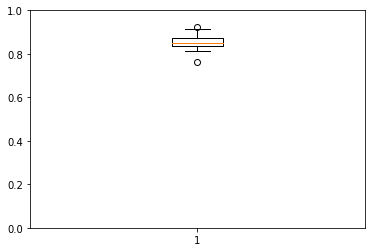

In [14]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

V = 10000
N = 400
gamma_pi = (1, 1)
gamma_theta = [1] * V
lmbda = 25

results = []
cnt = 0
while cnt < 10:
    accuracy = run_simulation(V, N, gamma_pi, gamma_theta, lmbda)
    results.append(accuracy)
    cnt += 1
    
print("Accuracy results: %s" % ", ".join("%0.3f" % x for x in results))
print("Average accuracy = %0.3f" % np.average(results))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylim([0,1])
plt.boxplot(results);

## <a id="the-end">The End</a> (Back to [Table of Contents](#table-of-contents))